In [1]:
#Causal eSTRs Enrichment
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as ss
import seaborn.apionly as sns
from collections import defaultdict

ANNOTDIR = "/storage/mgymrek/gtex/annotations/"
FEATUREDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
HTDIR = "/storage/mgymrek/gtex/tfbs/encodedata/"
BEDDIR = "/storage/mgymrek/gtex/annotations/encode/"
mergefile = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Best_causality.Table'
REGRSSION = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
SCORETYPE = ""
MINDIST = 1500 # For TSS

# Output path
OUTPATH = "pdfs"
PREFIX = "Figure2" # Keep as a variable in case we move things around!

# LIst of features to intersect with
"""
FEATURES = {
    "B_introns": os.path.join(ANNOTDIR, "introns.bed"),
    "C_3utr": os.path.join(ANNOTDIR, "3utr.bed"),
    "D_5utr": os.path.join(ANNOTDIR, "5utr.bed"),
    "E_promoter_1kb": os.path.join(ANNOTDIR, "hg19_promoter_1kb.bed"),
    "F_H3K4me1": os.path.join(HTDIR, "H3K4me1_GM12878.bed.gz"),
    "G_H3K4me2": os.path.join(HTDIR, "H3K4me2_GM12878.bed.gz"),
    "H_H3K4me3": os.path.join(HTDIR, "H3K4me3_GM12878.bed.gz"),
    "I_H3K27ac": os.path.join(HTDIR, "H3K27ac_GM12878.bed.gz"),
    "J_H3K27me3": os.path.join(HTDIR, "H3K27me3_GM12878.bed.gz"),
    "K_H3K36me3": os.path.join(HTDIR, "H3K36me3_GM12878.bed.gz"),  
}
"""
letters = ["A","B","C","D","E","F","G","H","I","J","K","L","M"]
i = 0
FEATURES = {}
for state in ["Active_Promoter","Weak_Promoter","Strong_Enhancer","Weak_Enhancer","Txn_Elongation","Txn_Transition","Weak_Txn","Heterochrom","Repressed"]:
    FEATURES[letters[i]+"_"+state] = os.path.join(BEDDIR,"%s_GM12878.bed"%state)
    i+= 1
#    "A_coding": os.path.join(ANNOTDIR, "coding.bed"),


Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
%%bash
# Get all STRs analyzed
BASEDIR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue
TISSUES=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/list_tissues
for t in $(cat $TISSUES)
do
    cat ${BASEDIR}/${t}/Lin_Reg_Out | grep -v gene | awk '{print $2 "\t" $4 "\t" $4+1}'
done | sort | uniq > all_analyzed_strs.bed

In [2]:
# Get features on all STRs analyzed - TODO update when we have all loci
all_strs = pd.read_csv("all_analyzed_strs.bed", sep="\t", names=["chrom","start","end"])
all_strs["locus"] = all_strs.apply(lambda x: x["chrom"]+":"+str(x["start"]), 1)
for key in FEATURES.keys():
    bedfile = FEATURES[key]
    cmd = "bedtools intersect -a all_analyzed_strs.bed -b %s > Intersect.bed"%bedfile
    returned_value = os.system(cmd)
    Inter = pd.read_csv('Intersect.bed', sep='\t', names=["chrom","start","end"])
    feature_loci = set(Inter.apply(lambda x: x["chrom"]+":"+str(x["start"]), 1))
    all_strs[key] = np.where(all_strs["locus"].isin(feature_loci), 1, 0)

In [3]:
# Get data on best STR per gene
data = pd.read_csv(mergefile, sep='\t')
data['str.start']=data['best.str.start']
GG   = pd.read_csv(REGRSSION, sep='\t')
data_best = pd.merge(data, GG[['chrom','str.start', 'gene','str.end','motif','E.tissues']], on=['chrom', 'str.start','gene' ] )

In [4]:
# TODO change these dfinitions
SCORE_THRESHOLD = 0.1 # causality score threshold
MINQ = 0.1 # FDR threshold for eSTR

data_best["is.estr"] = (data_best["best.q"]<=MINQ)
data_best["is.causal"] = data_best.apply(lambda x: "SNP" not in x["top.variant"] and x["best.score"]>=SCORE_THRESHOLD, 1)
data_best["is.causal.estr"] = (data_best["is.estr"] & data_best["is.causal"])
data_best["is.not.causal.e"]= data_best.apply(lambda x: "SNP" in x["top.variant"] and x["best.q"]<=MINQ, 1)

# Add features
data_best["start"] = data_best["best.str.start"]
data_best = pd.merge(data_best, all_strs)

print(data_best.shape,GG.shape ,data.shape)  #(11810, 31) (307187, 77) (11869, 11) if merger with inner

(11810, 30) (307187, 77) (11869, 11)


In [5]:
data_best[["is.estr","is.causal","is.causal.estr",'is.not.causal.e']]
all_strs.shape

(125758, 13)

In [6]:
OR_estr_vs_all = []
P_estr_vs_all = []

#OR_causal_vs_estr = []
#P_causal_vs_estr = []

OR_noncausal_vs_all = []
P_noncausal_vs_all = []

OR_causalestr_vs_all = []
P_causalestr_vs_all = []

keys = list(FEATURES.keys())

num_total_strs = all_strs.shape[0]
num_total_e_strs = sum(data_best["is.estr"])
num_total_noncausal = sum(data_best["is.not.causal.e"])
num_total_causal_e = sum(data_best["is.causal.estr"])

def NormTable(table, total):
    table[1][1] = total-sum(table)
    return table

for key in keys:
    num_total_feature = sum(all_strs[key])
    num_e_feature = sum(data_best[data_best["is.estr"]][key])
    num_causal_feature = sum(data_best[data_best["is.causal"]][key])
    num_causal_e_feature = sum(data_best[data_best["is.causal.estr"]][key])
    num_noncausal_e_feature = sum(data_best[data_best["is.not.causal.e"]][key])
        
    # eSTRs vs. non eSTRs 
    # [estr_feature, estr_nofeature]
    # [noestr_feature, none]
    table1 = [[num_e_feature, num_total_e_strs-num_e_feature],
            [num_total_feature-num_e_feature, 0]]
    
    table1 = NormTable(table1, num_total_strs)
    OR, p = ss.fisher_exact(table1)
    OR_estr_vs_all.append(OR)
    P_estr_vs_all.append(p)
    print(table1)
    
    """    
    # causal vs. all
    table2 = [[num_causal_feature, num_total_causal-num_causal_feature],
            [num_total_feature-num_causal_feature, 0]]
    table2 = NormTable(table2, num_total_strs)
    OR, p = ss.fisher_exact(table2)
    OR_causal_vs_all.append(OR)
    P_causal_vs_all.append(p)
    """        
    # causalestr vs. all
    # [causalestr_feature, causalestr_nofeature]
    # [nocausalestr_feature, none]
    table4 = [[num_causal_e_feature, num_total_noncausal - num_causal_e_feature],
            [num_total_feature-num_causal_e_feature, 0]]
    table4 = NormTable(table4, num_total_strs)
    OR, p = ss.fisher_exact(table4)
    OR_causalestr_vs_all.append(OR)
    P_causalestr_vs_all.append(p)
    print(table4)
    
    # Noncausalestr vs. all
    # [noncausalestr_feature, noncausalestr_nofeature]
    # [otherstr_feature, none]
    table5 = [[num_noncausal_e_feature, num_total_noncausal - num_noncausal_e_feature],
            [num_total_feature-num_noncausal_e_feature, 0]]
    table5 = NormTable(table5, num_total_strs)
    OR, p = ss.fisher_exact(table5)
    OR_noncausal_vs_all.append(OR)
    P_noncausal_vs_all.append(p)
    print(table5)

'''    "OR_causal_all": OR_causal_vs_all,
    "P_causal_all": P_causal_vs_all,
    #############,"OR_causal_all","P_causal_all"
'''    
    
        
enrich_table = pd.DataFrame({
    "feature": keys,
    "OR_estr_all": OR_estr_vs_all,
    "P_estr_all": P_estr_vs_all,
    "OR_noncausal_vs_all": OR_noncausal_vs_all,
    "P_noncausal_vs_all": P_noncausal_vs_all,
    "OR_causalestr_all": OR_causalestr_vs_all,
    "P_causalestr_all": P_causalestr_vs_all
})
enrich_table = enrich_table[["feature", "OR_estr_all","P_estr_all","OR_noncausal_vs_all","P_noncausal_vs_all",
                            "OR_causalestr_all","P_causalestr_all"]]

enrich_table.sort_values("feature")

[[500, 11310], [4492, 109456]]
[[116, 7212], [4876, 113554]]
[[313, 7015], [4679, 113751]]
[[199, 11611], [883, 113065]]
[[43, 7285], [1039, 117391]]
[[122, 7206], [960, 117470]]
[[342, 11468], [2237, 111711]]
[[82, 7246], [2497, 115933]]
[[204, 7124], [2375, 116055]]
[[249, 11561], [772, 113176]]
[[75, 7253], [946, 117484]]
[[140, 7188], [881, 117549]]
[[2547, 9263], [16021, 97927]]
[[604, 6724], [17964, 100466]]
[[1541, 5787], [17027, 101403]]
[[746, 11064], [4599, 109349]]
[[170, 7158], [5175, 113255]]
[[475, 6853], [4870, 113560]]
[[1582, 10228], [7072, 106876]]
[[403, 6925], [8251, 110179]]
[[899, 6429], [7755, 110675]]
[[232, 11578], [762, 113186]]
[[61, 7267], [933, 117497]]
[[144, 7184], [850, 117580]]
[[5290, 6520], [76148, 37800]]
[[1080, 6248], [80358, 38072]]
[[3408, 3920], [78030, 40400]]


,feature,OR_estr_all,P_estr_all,OR_noncausal_vs_all,P_noncausal_vs_all,OR_causalestr_all,P_causalestr_all
3,A_Active_Promoter,3.157483,4.104658e-45,2.598741,1.112800e-20,1.284196,4.378228e-02
7,B_Weak_Promoter,2.976406,8.134387e-39,2.772750,1.535297e-23,1.057109,6.830742e-01
2,C_Strong_Enhancer,1.489253,1.002845e-10,1.399286,1.407465e-05,0.525417,4.659528e-10
5,D_Weak_Enhancer,1.603164,2.914973e-28,1.616253,6.093677e-20,0.519762,7.899043e-20
6,E_Txn_Elongation,2.337511,5.350374e-156,1.995648,4.897477e-66,0.777101,7.456657e-07
1,F_Txn_Transition,2.194578,5.583964e-20,2.071673,6.143106e-12,0.666896,7.429212e-03
4,G_Weak_Txn,1.680700,1.263100e-96,1.585849,6.220635e-50,0.502372,1.329761e-67
8,H_Heterochrom,0.402755,0.000000e+00,0.450125,3.164552e-237,0.081895,0.000000e+00
0,I_Repressed,1.077227,1.247630e-01,1.084723,1.748830e-01,0.374577,1.041934e-33


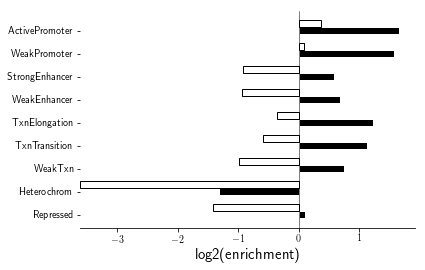

In [10]:
#Histone modification
# Plot (OR_estr_all, OR_causal_all)
enrich_table = enrich_table.sort_values("feature", ascending=False)

w = 0.3
fig = plt.figure()
ax = fig.add_subplot(111)
yvals = np.array(range(len(keys)))
bars1 = ax.barh(yvals, np.log2(enrich_table["OR_estr_all"]), height=w, color="black", edgecolor="white")
bars2 = ax.barh(yvals+w, np.log2(enrich_table["OR_causalestr_all"]), height=w, color="white", edgecolor="black")
ax.axvline(x=0, color="black", linewidth=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_yticks(yvals)
ax.set_yticklabels([item[2:].replace("_","") for item in enrich_table["feature"]]);
ax.set_xlabel("log2(enrichment)", size=15);
#fig.savefig(os.path.join(OUTPATH, "%s_causality_enrichment.pdf"%PREFIX))

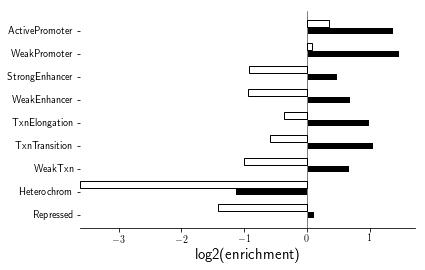

In [11]:
#Chromatin states
#Plot (OR_estr_all, OR_causal_all)
enrich_table = enrich_table.sort_values("feature", ascending=False)

w = 0.3
fig = plt.figure()
ax = fig.add_subplot(111)
yvals = np.array(range(len(keys)))
bars1 = ax.barh(yvals, np.log2(enrich_table["OR_noncausal_vs_all"]), height=w, color="black", edgecolor="white")
bars2 = ax.barh(yvals+w, np.log2(enrich_table["OR_causalestr_all"]), height=w, color="white", edgecolor="black")
ax.axvline(x=0, color="black", linewidth=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_yticks(yvals)
ax.set_yticklabels([item[2:].replace("_","") for item in enrich_table["feature"]]);
ax.set_xlabel("log2(enrichment)", size=15);
#fig.savefig(os.path.join(OUTPATH, "%s_causality_enrichment.pdf"%PREFIX))